In [1]:
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.optimizers import Adam,RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import Callback 
from keras.models import load_model
from keras.layers import GlobalAveragePooling2D, Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
from keras.layers.noise import AlphaDropout
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import time
import os
import psutil
import math
import pandas as pd
import numpy as np

c:\users\jordy\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


** Data set ** 

In [2]:
# Data set from https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)
df=pd.read_csv('data.csv',sep=',',header=None,encoding='latin-1')
df.values

X,y = df.iloc[:, 2:32], df.iloc[:,1]

X = np.array(X)
X = StandardScaler().fit_transform(X)
#X = MinMaxScaler().fit(X)
y = np.array(y)

# Separando Dataset
split1 = math.ceil(0.7 * X.shape[0]) # Separar 70% das imagens usadas para treino
split2 = math.ceil(0.8 * split1)

train_X = X[:split2]
test_X = X[split2:split1]

train_y = y[:split2]
test_y = y[split2:split1]

real_X = X[split1:]
real_Y = y[split1:]

#X, valid_X, Y, valid_Y = train_test_split(X, y, test_size=0.2, stratify = y)
#train_X,test_X,train_y,test_y = train_test_split(X, Y, test_size=0.2,stratify = y)

#train_X,test_X, Y_train, Y_test = train_test_split(X, y, test_size=0.3, stratify=y)

** Hiper parameters ** 

In [3]:
num_classes = 2
batch_size = 10
epochs = 200
lrn = 0.0001
activ = 'selu'

** One hot key ** 

In [4]:
encoder = LabelBinarizer()
train_y = encoder.fit_transform(train_y)
test_y = encoder.fit_transform(test_y)

train_Y = np_utils.to_categorical(train_y, num_classes)
test_Y = np_utils.to_categorical(test_y, num_classes)

real_Y = encoder.fit_transform(real_Y)
real_Y = np_utils.to_categorical(real_Y, num_classes)

** Neural Network ** 

In [5]:
def modelo():
    model = Sequential()    
    model.add(Dense(32,activation=activ, input_dim=30,kernel_initializer='lecun_normal'))
    model.add(AlphaDropout(0.15))
    model.add(Dense(64, activation=activ,kernel_initializer='lecun_normal'))
    model.add(AlphaDropout(0.15))
    model.add(Dense(128, activation=activ,kernel_initializer='lecun_normal'))
    model.add(AlphaDropout(0.15))
    model.add(Dense(128, activation=activ,kernel_initializer='lecun_normal'))
    model.add(AlphaDropout(0.15))  
    model.add(Dense(64, activation=activ,kernel_initializer='lecun_normal'))
    model.add(AlphaDropout(0.15))  
    model.add(Dense(32, activation=activ,kernel_initializer='lecun_normal'))
    model.add(AlphaDropout(0.15))
    model.add(Dense(num_classes, activation='softmax',kernel_initializer='lecun_normal'))

    model.summary()
    return model

In [6]:
modelo = modelo()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                992       
_________________________________________________________________
alpha_dropout_1 (AlphaDropou (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
alpha_dropout_2 (AlphaDropou (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
alpha_dropout_3 (AlphaDropou (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
__________

In [7]:
modelo.compile(loss='categorical_crossentropy',
               optimizer=RMSprop(lr=lrn, rho=0.9, epsilon=None, decay=0.0),
               metrics=['accuracy'])

** Salva modelo ** 

In [8]:
checkpoint = ModelCheckpoint('meuModelo.h5',
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=True,
                             mode='auto')

In [9]:
early = EarlyStopping(monitor='val_loss',
                      min_delta=0,
                      patience=0,
                      verbose=0, 
                      mode='auto')

** Treina modelo ** 

In [10]:
begin = time.time()
log = modelo.fit(train_X, train_Y,
                  batch_size = batch_size,
                  epochs = epochs,
                  validation_data = (test_X, test_Y),
                  #callbacks=[checkpoint],
                  callbacks=[checkpoint,early],                 
                  verbose=1)
duration = time.time() - begin

Train on 320 samples, validate on 79 samples
Epoch 1/200
320/320 [==============================] - 1s 2ms/step - loss: 0.6989 - acc: 0.6156 - val_loss: 0.1725 - val_acc: 0.9367
Epoch 2/200
320/320 [==============================] - 0s 210us/step - loss: 0.6188 - acc: 0.6563 - val_loss: 0.0770 - val_acc: 0.9873
Epoch 3/200
320/320 [==============================] - 0s 204us/step - loss: 0.5555 - acc: 0.7031 - val_loss: 0.0437 - val_acc: 0.9873
Epoch 4/200
320/320 [==============================] - 0s 197us/step - loss: 0.4513 - acc: 0.7750 - val_loss: 0.0288 - val_acc: 0.9873
Epoch 5/200
320/320 [==============================] - 0s 196us/step - loss: 0.3709 - acc: 0.8187 - val_loss: 0.0240 - val_acc: 0.9873
Epoch 6/200
320/320 [==============================] - 0s 197us/step - loss: 0.3384 - acc: 0.8594 - val_loss: 0.0192 - val_acc: 0.9873
Epoch 7/200
320/320 [==============================] - 0s 215us/step - loss: 0.3066 - acc: 0.8781 - val_loss: 0.0220 - val_acc: 0.9873


In [11]:
process = psutil.Process(os.getpid())
mem = process.memory_percent()
print("Memory used: % .2f MB" % mem)
print("Time: % .2f seconds" % duration)

Memory used:  1.35 MB
Time:  1.65 seconds


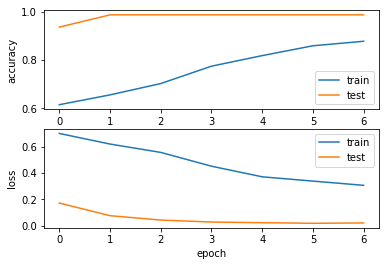

In [12]:
# summarize history for accuracy  
plt.subplot(211)  
plt.plot(log.history['acc'])  
plt.plot(log.history['val_acc'])  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(log.history['loss'])  
plt.plot(log.history['val_loss'])  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.show()  

In [13]:
# Carregar modelo salvo
# modelo = load_model("meuModelo.h5")
scores = modelo.evaluate(real_X,real_Y, verbose=0)
print("Accuracy: % .2f%%" % (scores[1]*100))

Accuracy:  97.06%
